In [ ]:
# ───────────────────── INSTALACIONES PREVIAS ─────────────────────────────
!pip install cartopy
!pip install unidecode
!pip install adjustText
import utils

In [ ]:
# ───────────────────── 1. LIBRERÍAS ─────────────────────────────
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt, matplotlib.dates as mdates
import matplotlib.colors as mcolors, matplotlib.cm as cm
from matplotlib.collections import LineCollection
from matplotlib.patches import Circle, FancyArrowPatch
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import cartopy.crs as ccrs
from matplotlib import colormaps
from pathlib import Path
import matplotlib.ticker as mticker
from utils import decimal_to_datetime, norm_dep, bezier
from matplotlib.lines import Line2D
import numpy as np
import matplotlib.lines as mlines
from matplotlib.patches import FancyArrowPatch
import random
import matplotlib.cm as cm
import matplotlib.colors as colors
from shapely.geometry import Point
from adjustText import adjust_text

In [ ]:
# ───────────────────── 2. CARGA DE DATOS ───────────────────────
# Lee el archivo
file = Path("data/Fig3_AllPeru_RegionDateMovements.txt")
df   = pd.read_csv(file, sep="\t")

# Convierte fechas decimales a datetime
for col in ("ParentDate", "ChildDate"):
    df[col] = df[col].apply(decimal_to_datetime)

# Normaliza nombres de regiones
for col in ("ParentRegion", "ChildRegion"):
    df[col] = df[col].apply(norm_dep)

# Agrega columnas de tiempo
df['año'] = df['ParentDate'].dt.year
df['mes'] = df['ParentDate'].dt.month
df['trimestre'] = df['ParentDate'].dt.quarter
df = df.sort_values('ParentDate')

# Agrupa movimientos por ruta única
df_count = df.groupby(["ParentRegion", "ChildRegion"]).size().reset_index(name="count")

# Define la normalización para color
min_count = df_count['count'].min()
max_count = df_count['count'].max()
print(f"Min count: {min_count}, Max count: {max_count}")  # ← para verificar que es 1 a 1556

## Normalización logarítmica para el colormap
norm = colors.Normalize(vmin=min_count, vmax=max_count)
cmap = cm.get_cmap('Purples')

Min count: 1, Max count: 1556


<ipython-input-79-5a275256aff4>:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Purples')


In [ ]:
# ───────────────────── 3. SHAPEFILE Y CENTROIDES ───────────────
shp = "data/DEPARTAMENTOS_inei_geogpsperu_suyopomalia/DEPARTAMENTOS_inei_geogpsperu_suyopomalia.shp"
gdf = gpd.read_file(shp)
# 1.  Proyección métrica adecuada para Perú  ──────────
#    UTM zona 18 Sur (EPSG:32718) cubre la mayor parte del país.
gdf_m = gdf.to_crs("EPSG:32718")
# 2.  Centroides en metros  ───────────────────────────
centroids_xy = gdf_m.centroid            # punto (x, y) en metros
# 3.  De vuelta a lon/lat  ───────────────────────────
centroids_ll = centroids_xy.to_crs("EPSG:4326")   # WGS-84

gdf["NOMBDEP"] = gdf["NOMBDEP"].apply(norm_dep)

# 4.  Diccionario {DEP: (lon, lat)}  ─────────────────
coords = {dep: (pt.x, pt.y)
          for dep, pt in zip(gdf["NOMBDEP"], centroids_ll)}

In [ ]:
# ───────────────────── 4. ESTADÍSTICAS PARA TAMAÑOS Y COLORES ──
donor_total = df["ParentRegion"].value_counts()
max_don     = donor_total.max()
size_lut    = ((donor_total / max_don) ** 0.5) * 900    # escala subjetiva

num_dates   = mdates.date2num(df["ParentDate"])
norm        = mcolors.Normalize(vmin=num_dates.min(), vmax=num_dates.max())
sm          = cm.ScalarMappable(norm=norm, cmap="viridis")

# paleta pastel para relleno de departamentos
N = len(gdf)                     # nº de departamentos
pastel = colormaps.get_cmap("Pastel2").resampled(N)
fill_color = {dep: pastel(i) for i, dep in enumerate(sorted(gdf["NOMBDEP"]))}

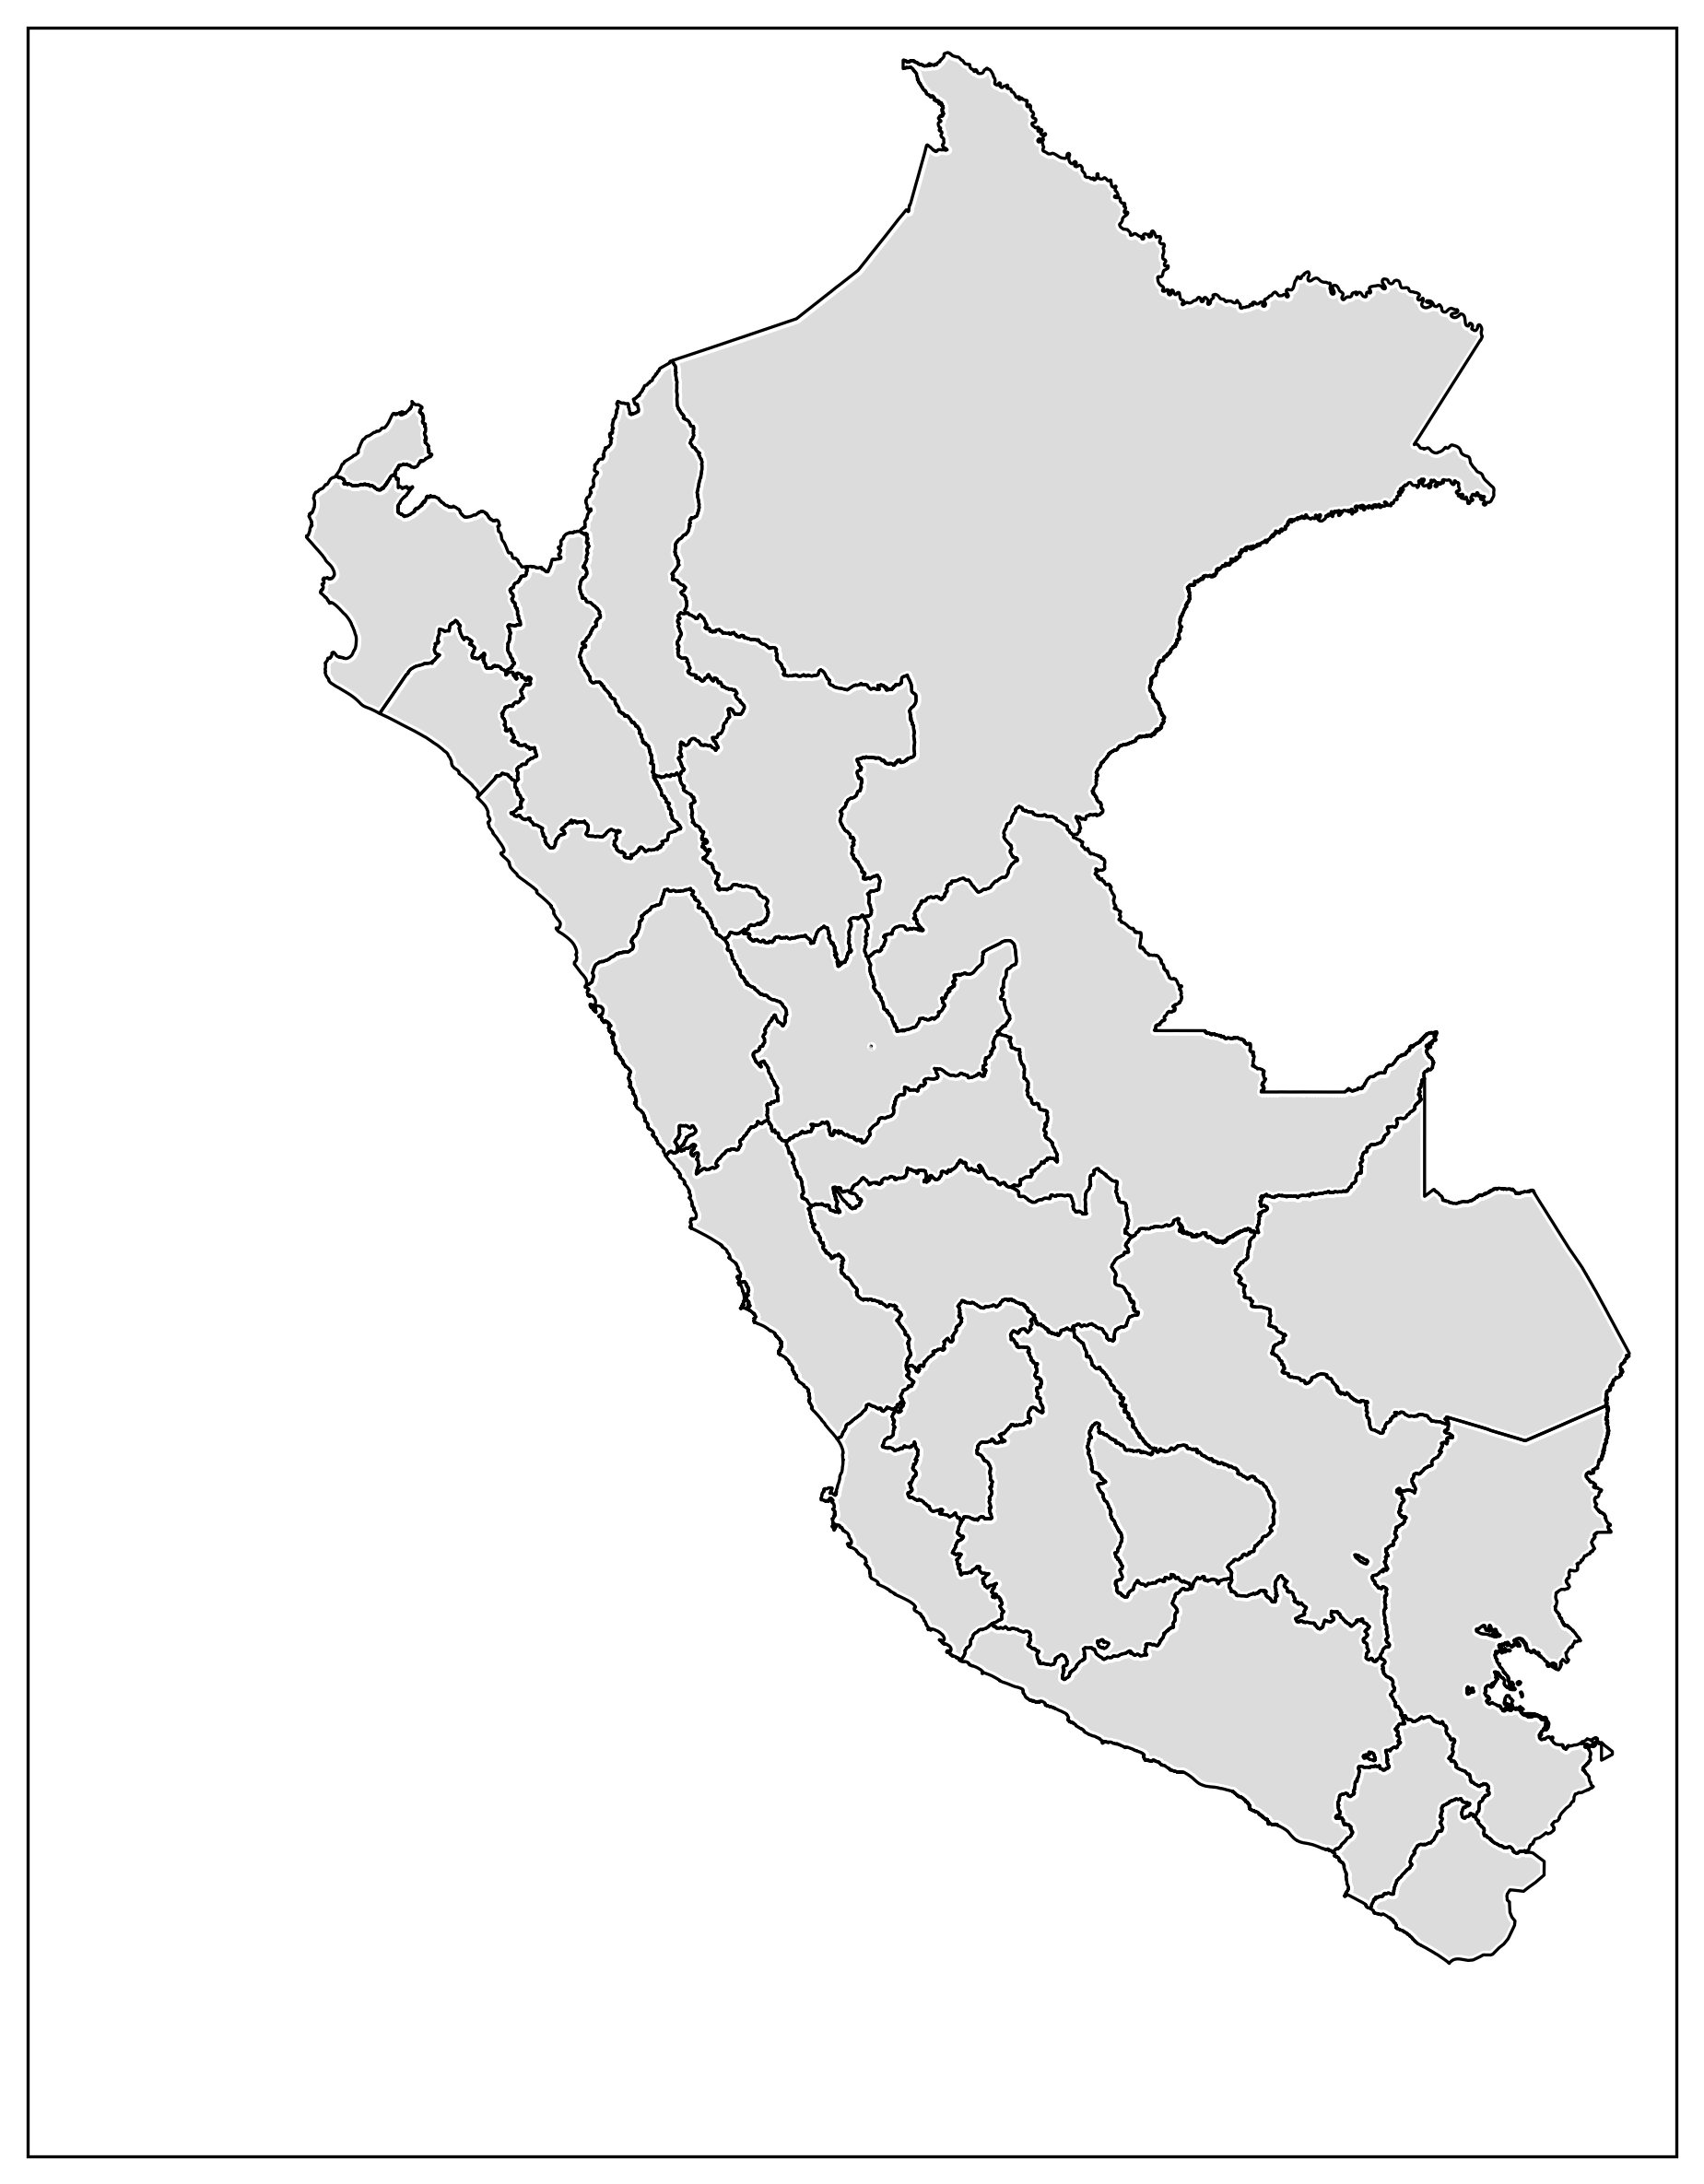

In [ ]:
# ───────────────────── 5. FIGURA Y MAPA BASE ───────────────────
fig = plt.figure(figsize=(8, 10), dpi=300)
ax  = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-84, -68.2, -20.2, 0.2])

# relleno pastel + borde doble (halo blanco + línea negra)
for dep, geom in zip(gdf["NOMBDEP"], gdf.geometry):
    ax.add_geometries([geom], ccrs.PlateCarree(),
                      # facecolor=fill_color[dep],
                      facecolor="gainsboro",     # <-- siempre el mismo
                      edgecolor="white",
                      linewidth=2.4, zorder=0)
    ax.add_geometries([geom], ccrs.PlateCarree(),
                      facecolor="none",
                      edgecolor="black",
                      linewidth=0.8, zorder=1)

In [ ]:
# ───────────────────── 6. ARCOS Y FLECHAS ──────────────────────
# Asegúrate de que la normalización logarítmica esté definida aquí
min_count = df_count['count'].min()
max_count = df_count['count'].max()
norm_log = colors.LogNorm(vmin=min_count, vmax=max_count)
# Cambia el colormap a uno que empiece en blanco y termine fuerte, por ejemplo 'Reds'
cmap = cm.get_cmap('Purples') # O 'Blues', 'Purples', 'Oranges', etc.

# Ordena df_count por 'count' en orden descendente
df_count_sorted = df_count.sort_values(by='count', ascending=False)

# Define un zorder máximo para las flechas
max_arrow_zorder = 100 # Ajusta este valor si es necesario

def bezier(x_start, y_start, x_end, y_end, rad=0.2, n_points=100):
    """
    Genera puntos de una curva de Bézier cuadrática entre dos puntos,
    con una curvatura especificada por `rad` y una cantidad de puntos `n_points`.
    """
    # Punto de control para la curva (curvatura)
    ctrl_x = (x_start + x_end) / 2 - rad * (y_end - y_start)
    ctrl_y = (y_start + y_end) / 2 + rad * (x_end - x_start)

    t = np.linspace(0, 1, n_points)
    x_vals = (1 - t)**2 * x_start + 2 * (1 - t) * t * ctrl_x + t**2 * x_end
    y_vals = (1 - t)**2 * y_start + 2 * (1 - t) * t * ctrl_y + t**2 * y_end

    return x_vals, y_vals

for _, row in df_count_sorted.iterrows():
    parent = row["ParentRegion"]
    child = row["ChildRegion"]
    count = row["count"]

    x_start, y_start = coords[parent]
    x_end, y_end = coords[child]

    rad = random.choice([-0.3, -0.2, -0.1, 0.1, 0.2, 0.3])
    color = cmap(norm_log(count))

    alpha_value = norm_log(count)
    alpha_value = max(0.1, min(0.9, alpha_value))

    if count > 1000:
        linewidth_value = 1.5
    elif count >= 500:
        linewidth_value = 1.0
    else:
        linewidth_value = 0.5

    zorder_value = max_arrow_zorder * (count - min_count) / (max_count - min_count)
    zorder_value = max(1, zorder_value)

    # (1) Dibuja curva con función bezier:
    x_vals, y_vals = bezier(x_start, y_start, x_end, y_end, rad, n_points=100)
    ax.plot(x_vals, y_vals, color=color, linewidth=linewidth_value, alpha=alpha_value,
            transform=ccrs.PlateCarree(), zorder=zorder_value)

    # (2) Flecha en punto medio de la curva:
    mid_idx = len(x_vals) // 2
    ax.annotate("",
        xy=(x_vals[mid_idx + 1], y_vals[mid_idx + 1]),
        xytext=(x_vals[mid_idx - 1], y_vals[mid_idx - 1]),
        arrowprops=dict(arrowstyle="->", color=color, lw=linewidth_value),
        annotation_clip=False,
        xycoords=ccrs.PlateCarree()._as_mpl_transform(ax),
        textcoords=ccrs.PlateCarree()._as_mpl_transform(ax),
        zorder=zorder_value + 1
    )

<ipython-input-83-e9391c760926>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Purples') # O 'Blues', 'Purples', 'Oranges', etc.


In [ ]:
# ───────────────────── 7. PUNTOS DE DENSIDAD DETALLADA ───────
try:
    df_densidad = pd.read_csv("data/densidad_poblacional.csv")

    if 'Departamento' in df_densidad.columns:
        df_densidad['Departamento'] = df_densidad['Departamento'].apply(norm_dep)
    else:
        print("Advertencia: Columna 'Departamento' no encontrada en el archivo de densidad detallada.")

    # Crea un diccionario {Departamento: Densidad}
    densidad_lut = df_densidad.set_index('Departamento')['Densidad'].to_dict()

    # Define cuántas personas representa cada punto
    personas_por_punto = 10000

    # Lista para almacenar las coordenadas de todos los puntos a dibujar
    all_density_points = []

    # Define el color y tamaño de los puntos de densidad
    punto_color = 'grey'
    punto_size = 0.5

    # Define un zorder para estos puntos de densidad
    density_points_zorder = 3


    # Itera sobre la geometría de cada departamento
    for dep, geom in zip(gdf["NOMBDEP"], gdf.geometry):
        if dep in densidad_lut:
            densidad_valor = densidad_lut[dep]

            # Calcula el número de puntos para este departamento
            num_points = int(densidad_valor / personas_por_punto)

            # Genera puntos aleatorios dentro de la geometría del departamento
            minx, miny, maxx, maxy = geom.bounds # Límites del departamento

            generated_points = []
            while len(generated_points) < num_points:
                # Genera una coordenada aleatoria dentro de los límites
                random_x = random.uniform(minx, maxx)
                random_y = random.uniform(miny, maxy)
                point = Point(random_x, random_y)

                # Verifica si el punto está dentro de la geometría del departamento
                if geom.contains(point):
                    generated_points.append((random_x, random_y))

            all_density_points.extend(generated_points)

    # Dibuja todos los puntos de densidad
    if all_density_points:
        x_coords, y_coords = zip(*all_density_points)
        ax.scatter(x_coords, y_coords, color=punto_color, s=punto_size, zorder=density_points_zorder, transform=ccrs.PlateCarree())
        print(f"Dibujados {len(all_density_points)} puntos de densidad.")
    else:
        print("No se generaron puntos de densidad.")

except FileNotFoundError:
    print("Error: El archivo 'densidad_poblacional.csv' no fue encontrado.")
except KeyError as e:
    print(f"Error de columna en el archivo de densidad: {e}")
except Exception as e:
    print(f"Ocurrió un error inesperado: {e}")

Dibujados 3427 puntos de densidad.


In [ ]:
# ───────────────────── 8. PUNTOS Y ETIQUETAS ───────────────────
FACE = (0.886, 0.290, 0.200, 0.8)  # naranja-rojo 80 %
label_zorder = max_arrow_zorder + 10 # Un valor mayor que el zorder máximo de las flechas

# Lista para almacenar los objetos de texto
texts = []

for dep, (lon, lat) in coords.items():
    size_px = size_lut.get(dep, 80)
    circ = Circle((lon, lat), size_px/2200, facecolor=FACE,
                  edgecolor="white", lw=0.6, zorder=4,
                  transform=ccrs.PlateCarree())
    ax.add_patch(circ)

    # --- Ajuste Manual de Coordenadas para Departamentos Específicos ---
    adjusted_lon = lon
    adjusted_lat = lat
    offset_lat = 0.15 if lat > -10 else -0.15 # Offset vertical base
    offset_lon = 0.05 # Offset horizontal base

    # Ajustes específicos basados en la observación de los solapamientos
    if dep == 'Lambayeque':
        adjusted_lon -= 0.5 # Mover ligeramente a la izquierda
        adjusted_lat += 0.5 # Mover ligeramente hacia arriba
    elif dep == 'Cajamarca':
        adjusted_lon += 0.35 # Mover ligeramente a la derecha
        adjusted_lat -= 0.35 # Mover ligeramente hacia abajo
    elif dep == 'Lima':
         adjusted_lon += 0.15 # Mover más a la derecha
         offset_lat += 0.1 # Añadir un offset vertical extra
    elif dep == 'Callao':
         adjusted_lon -= 0.15 # Mover más a la izquierda
         offset_lat -= 0.1 # Añadir un offset vertical extra (negativo)
    elif dep == 'Ayacucho':
         adjusted_lon -= 0.1 # Mover ligeramente a la izquierda
         offset_lat += 0.08 # Añadir un offset vertical extra
    elif dep == 'Apurimac':
         adjusted_lon += 0.1 # Mover ligeramente a la derecha
         offset_lat -= 0.08 # Añadir un offset vertical extra (negativo)

    # Aplica el offset (base + manual si aplica)
    final_lon = adjusted_lon + offset_lon
    final_lat = adjusted_lat + offset_lat

    # Crea el objeto de texto con las coordenadas ajustadas
    texts.append(ax.text(final_lon, final_lat, dep.title(),
                          fontsize=8, ha="left", va="center", zorder=label_zorder,
                          bbox=dict(facecolor="white", alpha=.7, pad=1, lw=0),
                          transform=ccrs.PlateCarree()))

# Después del bucle, llama a adjust_text con parámetros de force_points y force_text razonables
adjust_text(texts, ax=ax,
            force_points=(1.0, 1.0), # Ajusta estos valores según necesites la separación general
            force_text=(1.0, 1.0),
            expand_points=(1.1, 1.1),
            expand_text=(1.1, 1.1),
            arrowprops=dict(arrowstyle='-', color='red', lw=0.5)) # Opciones para el ajuste

([Text(-77.19845921395566, -4.804388517361659, 'Amazonas'),
  Text(-77.04980379554772, -9.118511427758959, 'Ancash'),
  Text(-71.9821001480222, -14.02789428317455, 'Apurimac'),
  Text(-71.73024808775703, -16.05566244013919, 'Arequipa'),
  Text(-73.54731428371937, -14.494804043519002, 'Ayacucho'),
  Text(-77.83056459879926, -6.361044349183672, 'Cajamarca'),
  Text(-76.64602314784618, -12.258101195394099, 'Callao'),
  Text(-71.65173442994447, -13.36320745741653, 'Cusco'),
  Text(-73.91073034929867, -13.032232983930518, 'Huancavelica'),
  Text(-75.28868915702684, -9.327932032577875, 'Huanuco'),
  Text(-75.29318459845122, -14.365501480485863, 'Ica'),
  Text(-74.439054572629, -11.741711538725278, 'Junin'),
  Text(-77.44815090683434, -7.894958086796326, 'La Libertad'),
  Text(-78.83125374085036, -6.013665254458054, 'Lambayeque'),
  Text(-76.14350576495865, -11.801155360473645, 'Lima'),
  Text(-73.88120151394219, -3.9938941031636155, 'Loreto'),
  Text(-69.34329436111571, -12.263800069413648, 

In [ ]:
# ───────────────────── 9. ESCALA 200 km ───────────────────────
bar = AnchoredSizeBar(ax.transData, 1.2, '200 km', loc=3,
                      pad=0.6, color='black',
                      frameon=False, size_vertical=0.10)
ax.add_artist(bar)

In [ ]:
# ───────────────────── 10. TÍTULO Y PIE ────────────────────────
plt.suptitle("Dispersión de linajes virales entre departamentos del Perú (2020-2024)",
             fontsize=13, fontweight='bold', y=0.988)
bbox = ax.get_position()
# caption = (
#     "Figura 1 | Arcos coloreados según la fecha origen del evento (ParentDate). Los círculos se escalan al número total de eventos registrados \n"
#     "como origen para cada departamento. El fondo muestra los límites administrativos proporcionados por el INEI."
# )
# Bbox(x0, y0, x1, y1)
# Opcional: envolver a ~90 caracteres para evitar líneas ultra-largas
# wrapped = "\n".join(textwrap.wrap(caption, 90))
# ── 3. Coordenadas del centro del mapa ─────────────────────────
# x_center = bbox.x0 + bbox.width / 2
# y_bottom = 0.01                # distancia vertical en fracción de figura
# ── 4. Dibujar texto centrado y con alineación adecuada ────────
# fig.text(
#     x_center, y_bottom,
#     caption,
#     ha="center", va="bottom",
#     fontsize=6.5,
#     wrap=True                  # Matplotlib ≥3.4 respeta saltos automáticos
# )

<Figure size 640x480 with 0 Axes>

In [ ]:
# ───────────────────── 11. LEYENDA COMBINADA ────────────────────────

# Define los rangos de cantidad y sus propiedades de visualización
legend_ranges = [
    (1, 50, 0.5, 'Low'),
    (51, 500, 0.8, 'Medium-Low'),
    (501, 1000, 1.2, 'Medium-High'),
    (1001, max_count, 1.8, 'High')
]

# Crea una lista de manejadores de leyenda personalizados
legend_handles = []
legend_labels = []

# Asegúrate de tener definida la normalización y el colormap
min_count = df_count['count'].min()
max_count = df_count['count'].max()
norm_log = colors.LogNorm(vmin=min_count, vmax=max_count)
cmap = cm.get_cmap('Purples')

for min_val, max_val, linewidth, label_range in legend_ranges:
    representative_count = (min_val + max_val) / 2
    try:
        color = cmap(norm_log(representative_count))
    except ValueError:
        if representative_count < min_count:
            color = cmap(norm_log(min_count))
        else:
            color = cmap(norm_log(max_count))

    handle = Line2D([0], [0], color=color, lw=linewidth)
    legend_handles.append(handle)
    legend_labels.append(f'{label_range}: {min_val}-{max_val}')

# --- Leyenda para Puntos de Densidad Poblacional ---
legend_point_color = 'grey'
legend_point_size = 10
legend_density_handle = Line2D([0], [0], marker='o', color='w', label='10,000 people',
                       markerfacecolor=legend_point_color, markersize=legend_point_size)

# --- Creación de las Leyendas ---

# Crea la leyenda combinada (color y grosor)
# Coloca esta leyenda debajo de la leyenda de densidad poblacional
legend_combined = ax.legend(handles=legend_handles, labels=legend_labels,
                            title="Number of Dispersions",
                            loc='lower left',
                            bbox_to_anchor=(0, 0.06),
                            ncol=2,
                            frameon=True)

ax.add_artist(legend_combined)

# Agrega la leyenda de densidad poblacional
# Coloca esta leyenda encima de la leyenda combinada
legend_density = ax.legend(handles=[legend_density_handle], title="Population Density",
                           loc='lower left',
                           bbox_to_anchor=(0, 0.17))

ax.add_artist(legend_density)

<ipython-input-88-ee5086aa2733>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Purples')


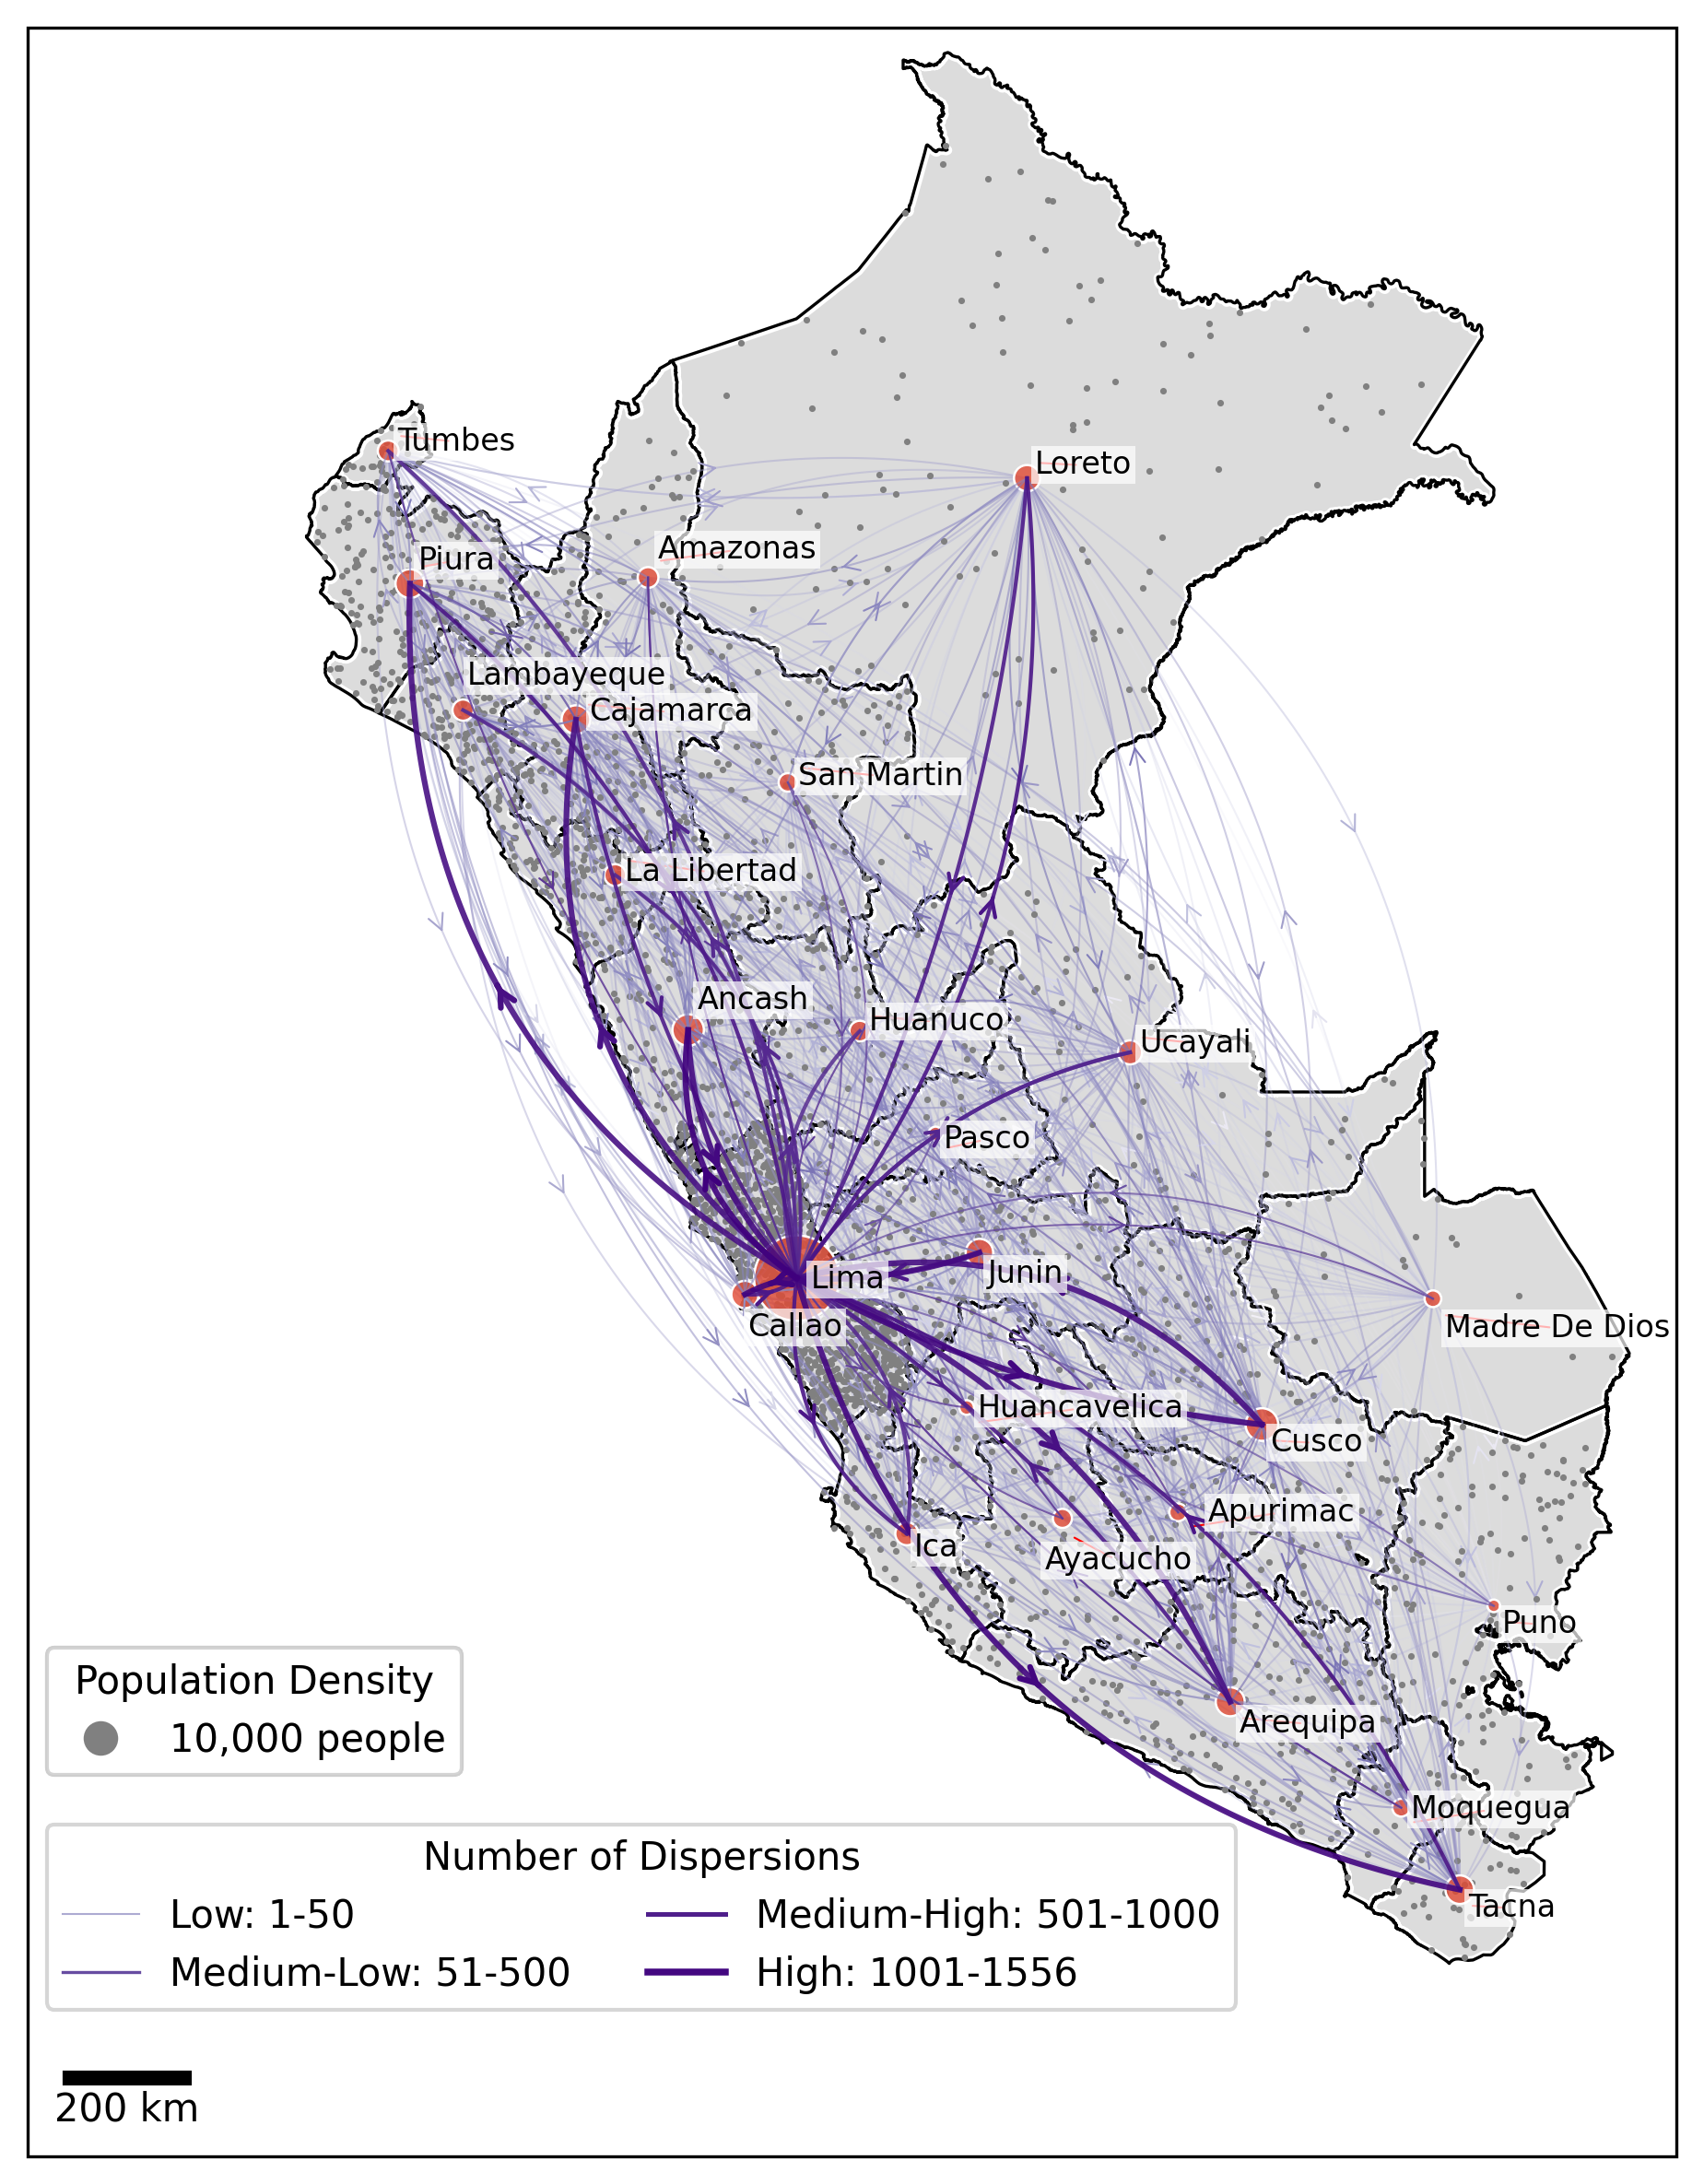

In [ ]:
# ───────────────────── 12. GUARDAR Y MOSTRAR ───────────────────
fig.savefig("output/Movimientos_Departamentales_Peru_año.png", dpi=600, bbox_inches="tight")
plt.show()
fig

In [ ]:
# ───────────────────── ADICIONAL #1. CONTEO DE MOVIMIENTOS POR RUTA ───────────────────

# Carga del archivo
df = pd.read_csv("data/Fig3_AllPeru_RegionDateMovements.txt", sep="\t")  # Usa sep="," si fuera CSV

# Cuenta el número de movimientos por ruta (origen-destino)
# Usar los nombres correctos de las columnas: 'ParentRegion' y 'ChildRegion'
ruta_counts = df.groupby(['ParentRegion', 'ChildRegion']).size().reset_index(name='cantidad_de_movimientos')

# Ordena por cantidad
ruta_counts = ruta_counts.sort_values(by='cantidad_de_movimientos', ascending=False)

print(ruta_counts)

    ParentRegion ChildRegion  cantidad_de_movimientos
337         Lima      Ancash                     1556
342         Lima      Callao                     1390
343         Lima       Cusco                     1301
357         Lima       Tacna                     1294
37        Ancash        Lima                     1255
..           ...         ...                      ...
480         Puno    Amazonas                        2
235      Huanuco        Puno                        2
451        Pasco        Puno                        2
498         Puno       Pasco                        1
484         Puno    Ayacucho                        1

[600 rows x 3 columns]


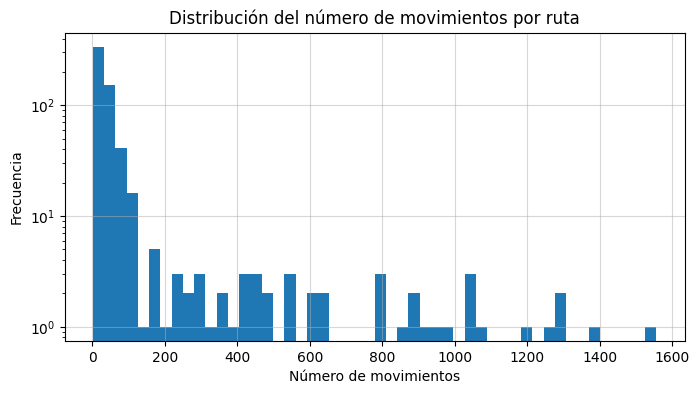

In [ ]:
# ───────────────────── ADICIONAL #2. HISTOGRAMA DE MOVIMIENTOS POR RUTA ───────────────────

import matplotlib.pyplot as plt
import seaborn as sns # Opcional, para gráficos más bonitos

plt.figure(figsize=(8, 4))
# sns.histplot(df_count['count'], bins=50, kde=True) # Con seaborn
plt.hist(df_count['count'], bins=50) # Con matplotlib básico
plt.title('Distribución del número de movimientos por ruta')
plt.xlabel('Número de movimientos')
plt.ylabel('Frecuencia')
plt.yscale('log') # Usa escala logarítmica en y si hay muchos valores bajos
plt.grid(True, alpha=0.5)
plt.show()